In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
columns = ["engine_id", "time"] + ["operational_setting" + str(i) for i in range(1,4)] + [
"(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]

df = pd.read_csv("CMAPSSData/train_FD001.txt", sep = " ", header = None)
df.drop(axis=1, columns=[26, 27], inplace=True) # odrzuć źle wczytane kolumny
df.columns = columns
df

engine_id  time  operational_setting1  operational_setting2  \
0              1     1               -0.0007               -0.0004   
1              1     2                0.0019               -0.0003   
2              1     3               -0.0043                0.0003   
3              1     4                0.0007                0.0000   
4              1     5               -0.0019               -0.0002   
...          ...   ...                   ...                   ...   
20626        100   196               -0.0004               -0.0003   
20627        100   197               -0.0016               -0.0005   
20628        100   198                0.0004                0.0000   
20629        100   199               -0.0011                0.0003   
20630        100   200               -0.0032               -0.0005   

       operational_setting3  (Fan inlet temperature) (◦R)  \
0                     100.0                        518.67   
1                     100.0                        518.67   
2                     100.0                        518.67   
3                     100.0                        518.67   
4                     100.0                        518.67   
...                     ...                           ...   
20626                 100.0                        518.67   
20627                 100.0                        518.67   
20628                 100.0                        518.67   
20629                 100.0                        518.67   
20630                 100.0                        518.67   

       (LPC outlet temperature) (◦R)  (HPC outlet temperature) (◦R)  \
0                             641.82                        1589.70   
1                             642.15                        1591.82   
2                             642.35                        1587.99   
3                             642.35                        1582.79   
4                             642.37                        1582.85   
...                              ...                            ...   
20626                         643.49                        1597.98   
20627                         643.54                        1604.50   
20628                         643.42                        1602.46   
20629                         643.23                        1605.26   
20630                         643.85                        1600.38   

       (LPT outlet temperature) (◦R)  (Fan inlet Pressure) (psia)  ...  \
0                            1400.60                        14.62  ...   
1                            1403.14                        14.62  ...   
2                            1404.20                        14.62  ...   
3                            1401.87                        14.62  ...   
4                            1406.22                        14.62  ...   
...                              ...                          ...  ...   
20626                        1428.63                        14.62  ...   
20627                        1433.58                        14.62  ...   
20628                        1428.18                        14.62  ...   
20629                        1426.53                        14.62  ...   
20630                        1432.14                        14.62  ...   

       (Ratio of fuel flow to Ps30) (pps/psia)  (Corrected fan speed) (rpm)  \
0                                       521.66                      2388.02   
1                                       522.28                      2388.07   
2                                       522.42                      2388.03   
3                                       522.86                      2388.08   
4                                       522.19                      2388.04   
...                                        ...                          ...   
20626                                   519.49                      2388.26   
20627                                   519.68             

In [3]:

df.nunique()

engine_id                                   100
time                                        362
operational_setting1                        158
operational_setting2                         13
operational_setting3                          1
(Fan inlet temperature) (◦R)                  1
(LPC outlet temperature) (◦R)               310
(HPC outlet temperature) (◦R)              3012
(LPT outlet temperature) (◦R)              4051
(Fan inlet Pressure) (psia)                   1
(bypass-duct pressure) (psia)                 2
(HPC outlet pressure) (psia)                513
(Physical fan speed) (rpm)                   53
(Physical core speed) (rpm)                6403
(Engine pressure ratio(P50/P2)                1
(HPC outlet Static pressure) (psia)         159
(Ratio of fuel flow to Ps30) (pps/psia)     427
(Corrected fan speed) (rpm)                  56
(Corrected core speed) (rpm)               6078
(Bypass Ratio)                             1918
(Burner fuel-air ratio)                 

### Drop constant or nearly constant columns


In [4]:
df = df.loc[:, df.nunique() > 13]

### Max cycles histogram


<Axes: >

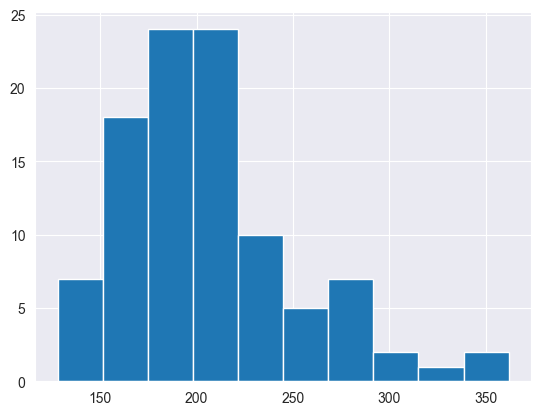

In [5]:
df.groupby(["engine_id"])["time"].max().hist()

### drop outliers

In [6]:
ids_to_drop = df.loc[df['time'] > 300, 'engine_id'].unique()
df = df[~df['engine_id'].isin(ids_to_drop)]

<Axes: >

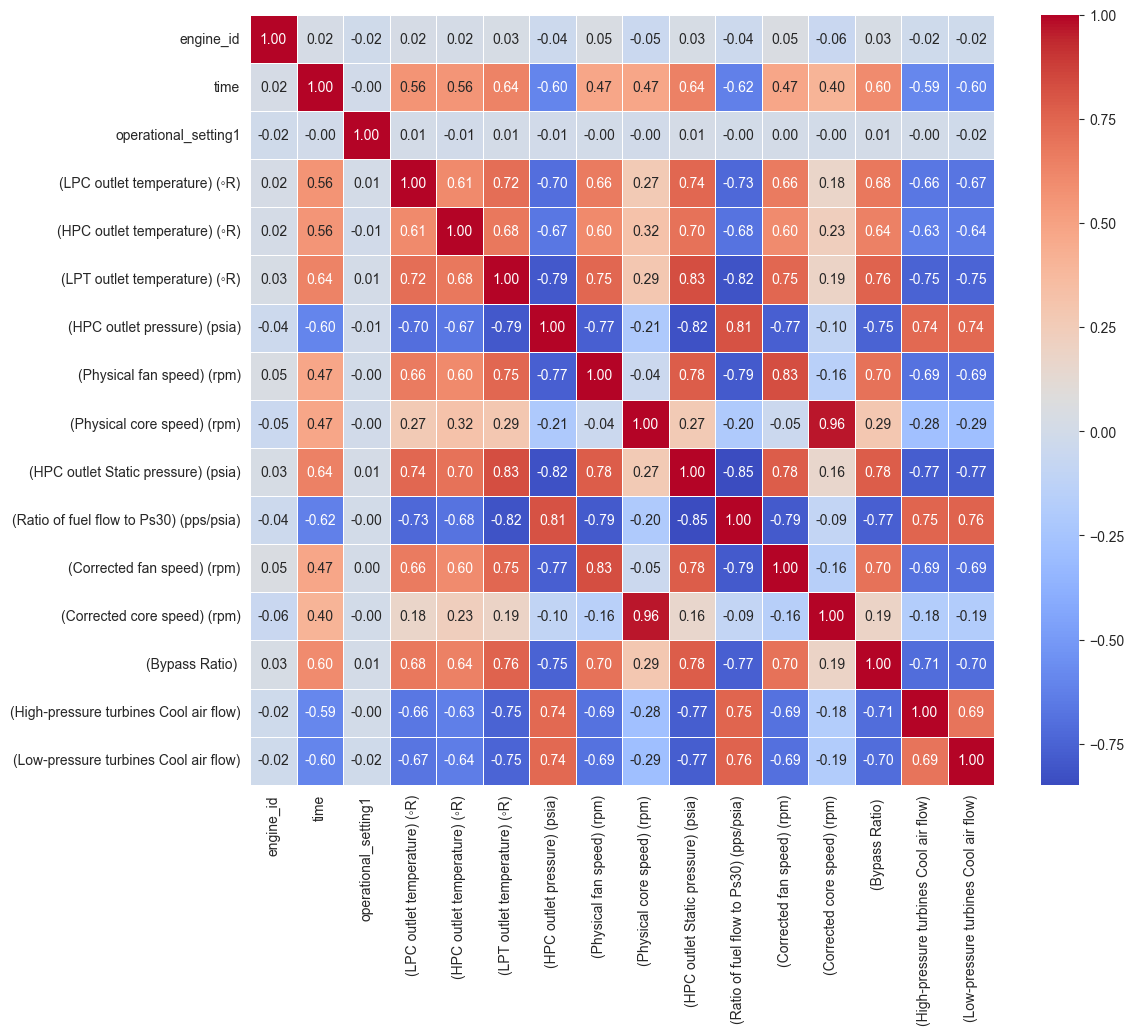

In [7]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

In [8]:
def draw_time_series(df, engine_id):

    columns_to_smooth = [col for col in df.columns if col not in ['time', 'engine_id']]  # Exclude 'time' column
    filtered_df = df[df['engine_id'] == engine_id]
    df_averaged = filtered_df.copy()
    for col in columns_to_smooth:
        df_averaged[col+" rolling"] = filtered_df[col].rolling(window=window_size, min_periods=1).mean()

    columns_to_plot = [col for col in df_averaged.columns if col not in ['engine_id', 'time'] and "rolling" not in col ]

    num_columns = len(columns_to_plot)
    fig, axes = plt.subplots(nrows=num_columns//2, ncols=2, figsize=(24, num_columns * 2), sharex=True)
    axes = axes.flatten()
    fig.subplots_adjust(hspace=0.5)

    for i, column in enumerate(columns_to_plot):
        axes[i].plot(df_averaged['time'], df_averaged[column], label=column)
        axes[i].plot(df_averaged['time'], df_averaged[column+" rolling"], label=column + " rolling average")
        axes[i].grid(True)
        axes[i].legend(loc="upper left", fontsize=8)

    axes[-1].set_xlabel("Time")
    fig.suptitle(f"Time series for engine_id {engine_id}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

<Axes: >

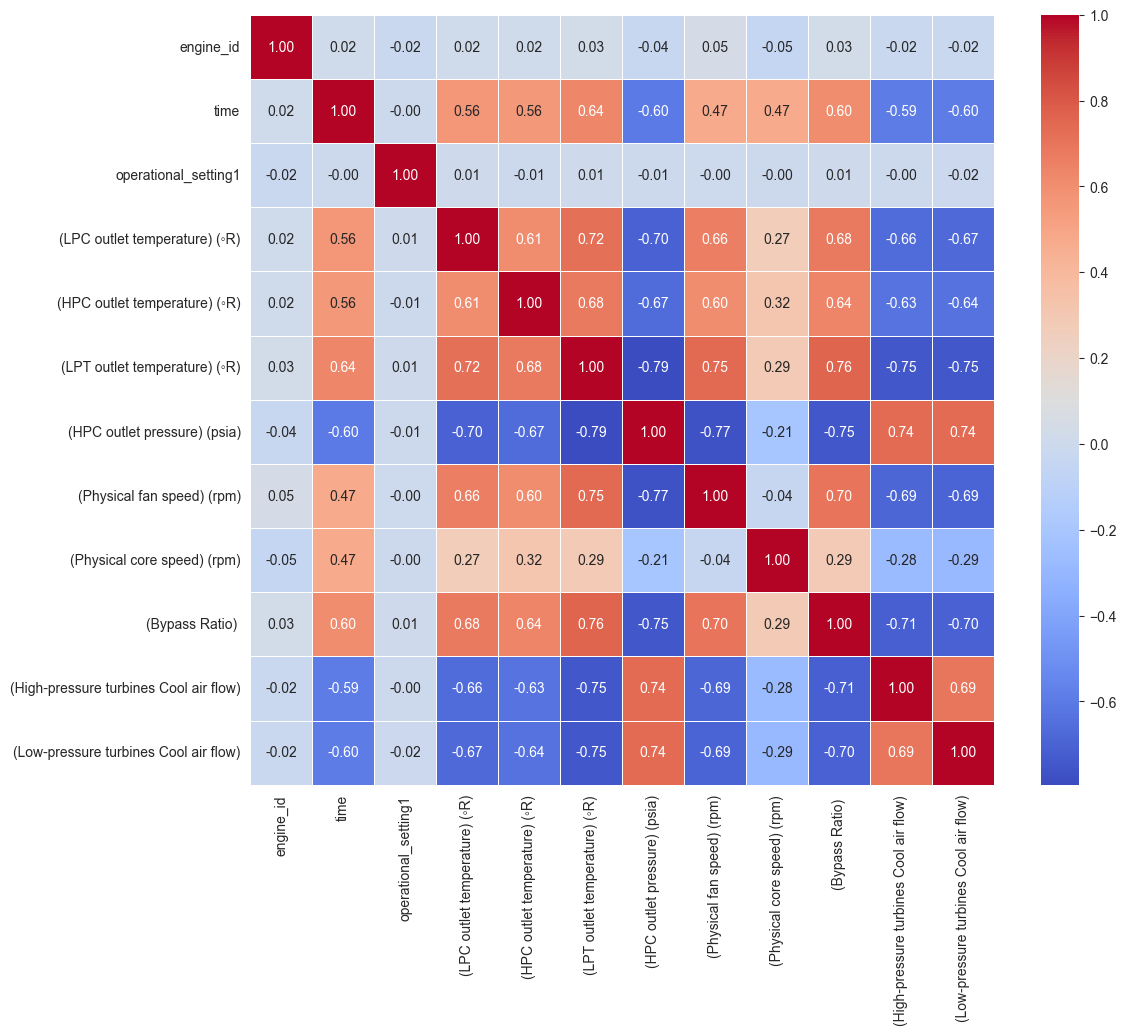

In [9]:
corr_matrix = df.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

# Drop features
df.drop(to_drop, axis=1, inplace=True)
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

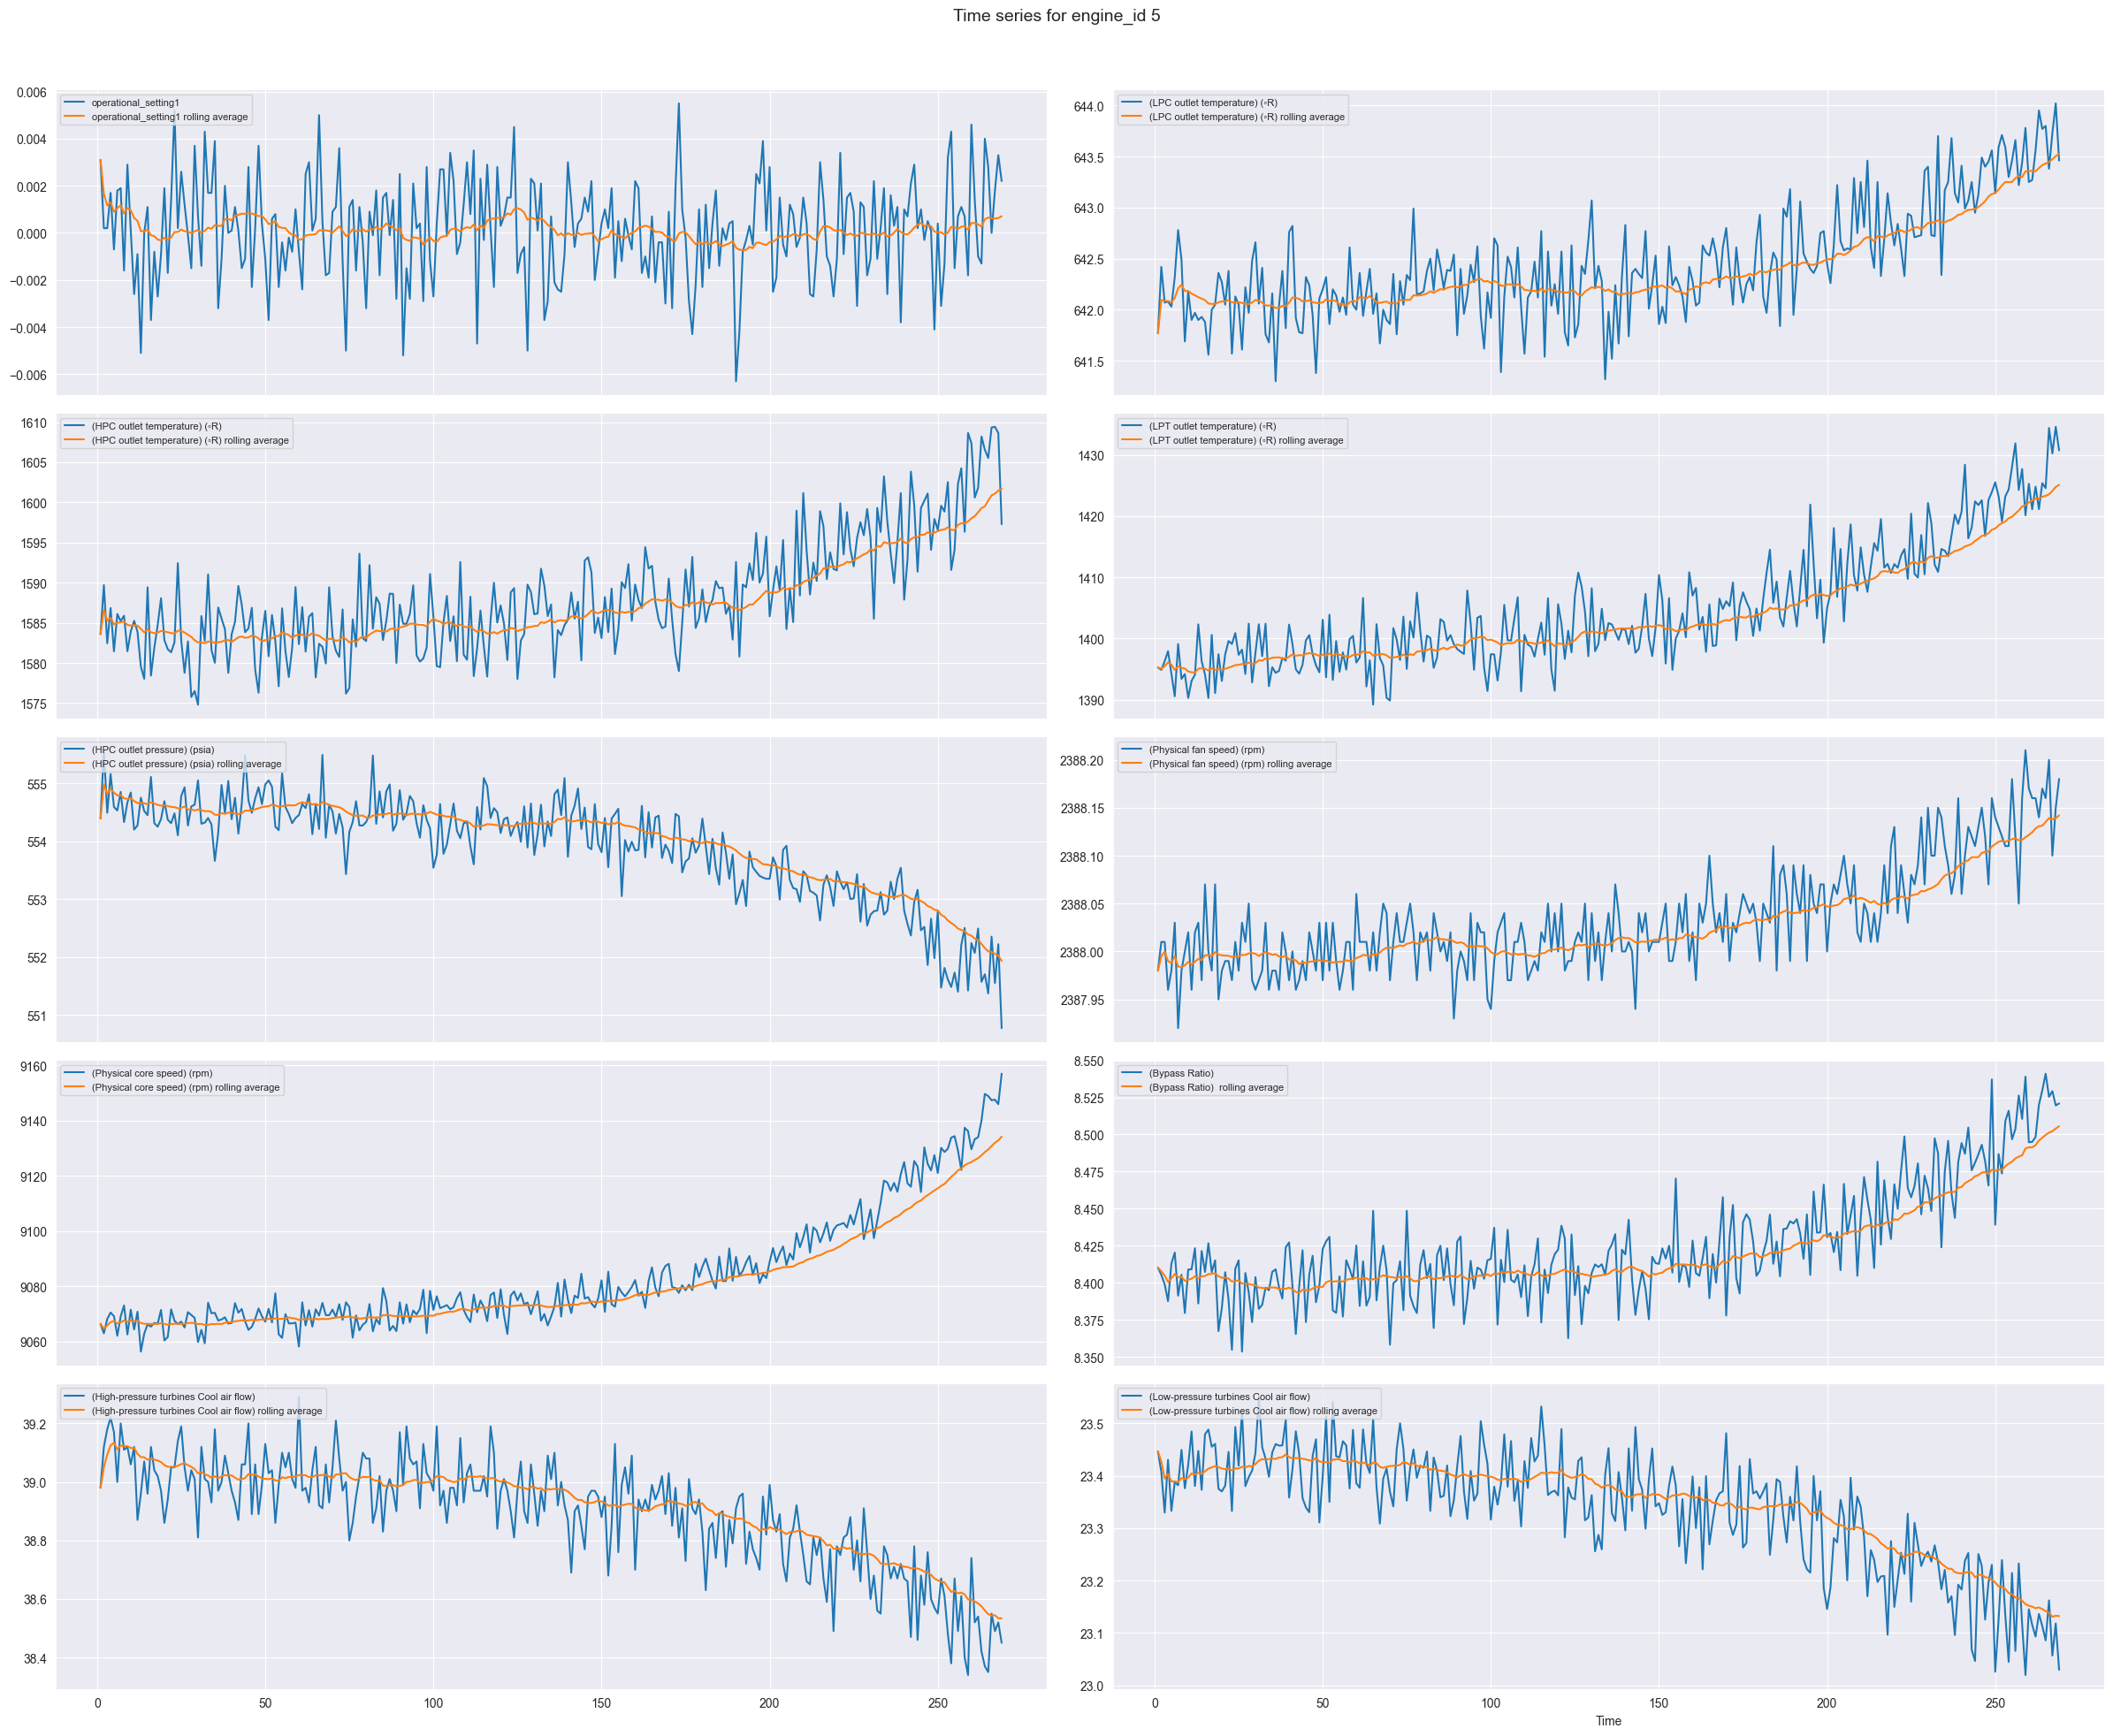

In [10]:
#rolling window size
window_size = 25
engine_id = 5

draw_time_series(df, engine_id)

In [11]:
def draw_time_series_for_all_engines(df):

    columns_to_smooth = [col for col in df.columns if col not in ['time', 'engine_id']]

    for col in columns_to_smooth:
        df[col] = df.groupby('engine_id')[col].rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)

    averaged_rolling = df.groupby('time')[columns_to_smooth].mean()
    median_rolling = df.groupby('time')[columns_to_smooth].median()

    fig, axes = plt.subplots(nrows=len(columns_to_smooth)//2, ncols=2, figsize=(12, len(columns_to_smooth) * 2), sharex=True)
    axes = axes.flatten()
    fig.subplots_adjust(hspace=0.5)

    for i, column in enumerate(columns_to_smooth):
        axes[i].plot(averaged_rolling.index, averaged_rolling[column], label=f'Average Rolling mean {column}')
        axes[i].plot(median_rolling.index, median_rolling[column], label=f'Average Rolling median {column}')
        axes[i].set_title(f'Average Rolling mean/median for {column}')
        axes[i].grid(True)
        axes[i].legend(loc="upper left", fontsize=8)

    axes[-1].set_xlabel("Time")
    fig.suptitle(f"Average Rolling mean/average for all Engines", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

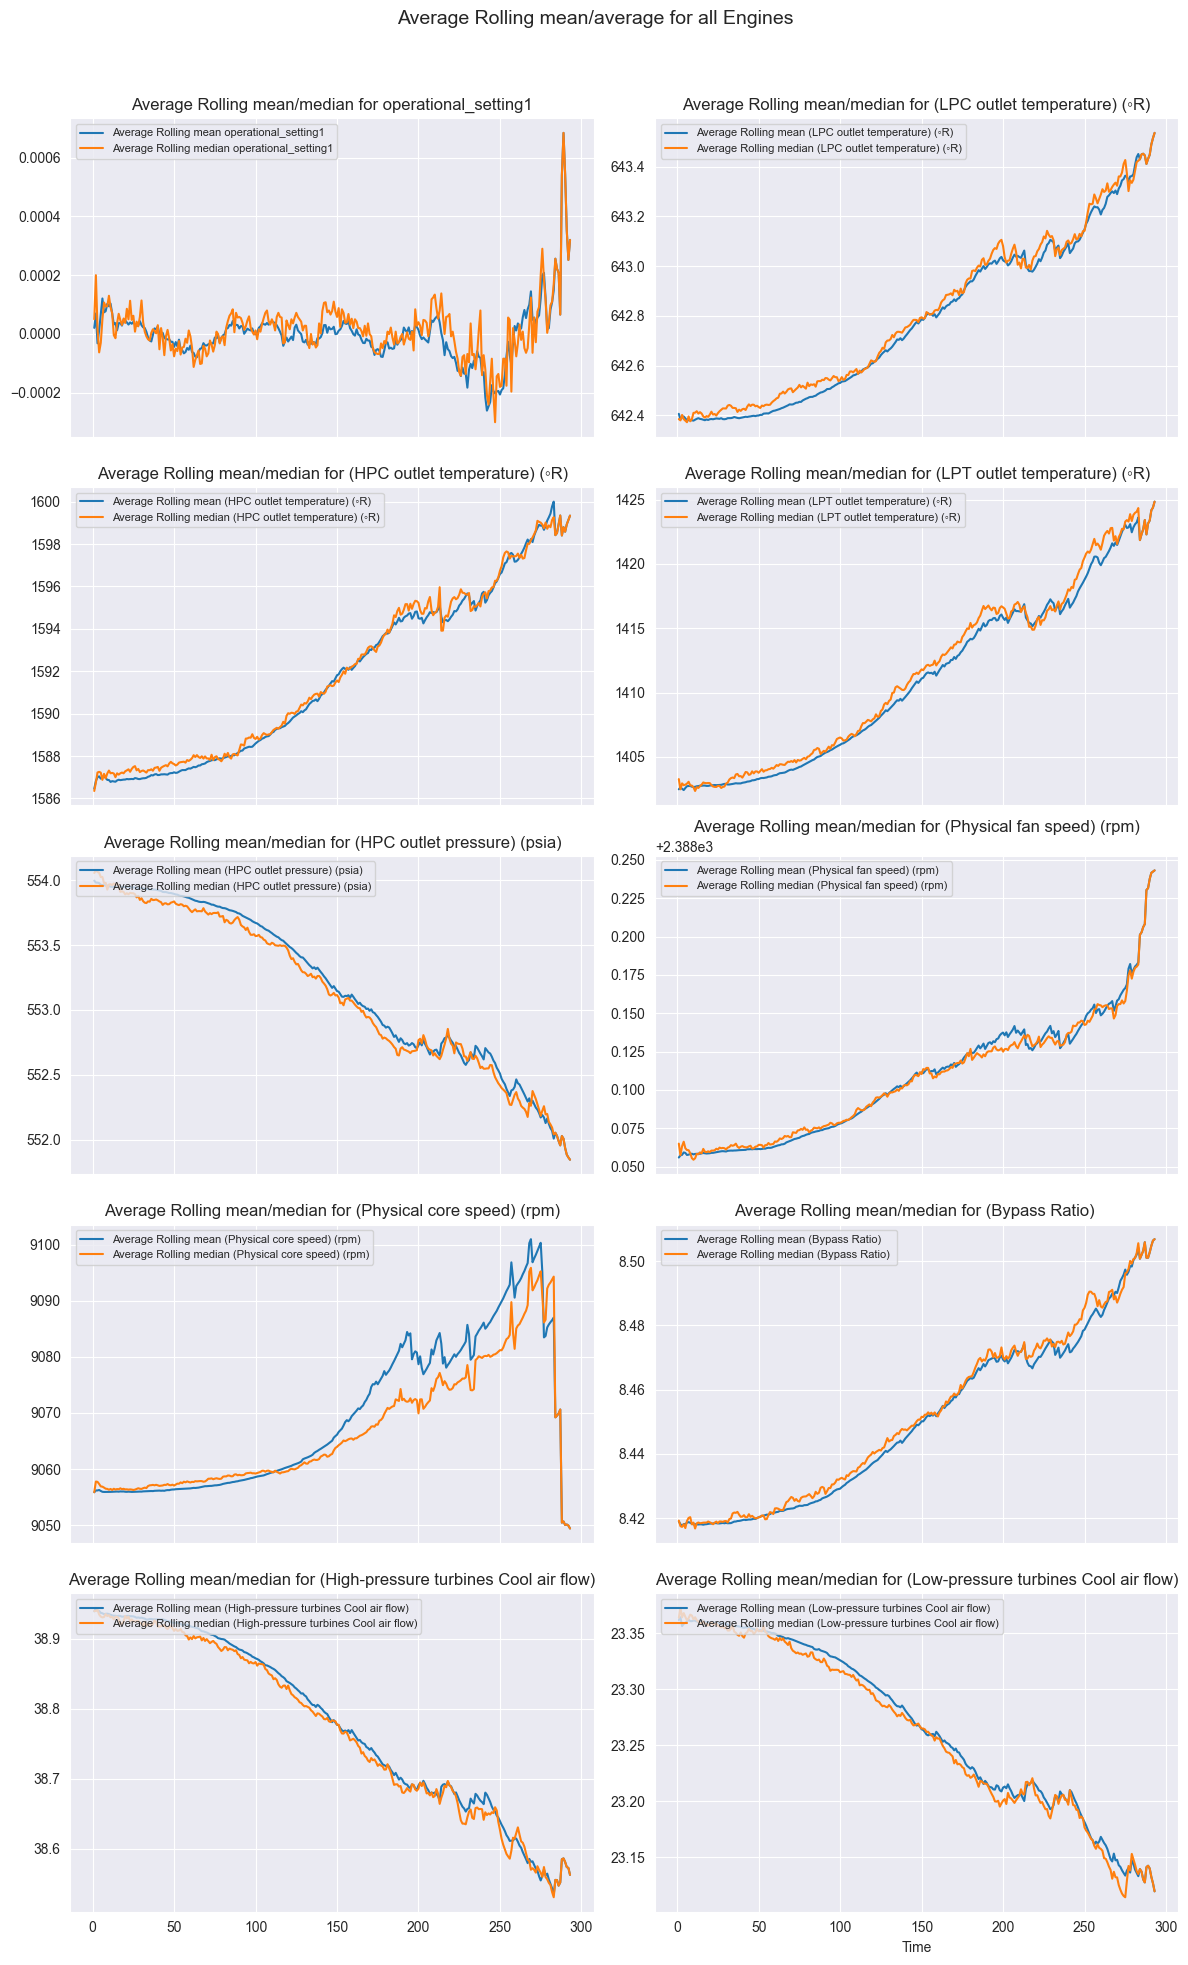

In [12]:
draw_time_series_for_all_engines(df)

In [23]:
df['rul'] = df.groupby('engine_id')['time'].transform('max') - df['time']
from sklearn.model_selection import train_test_split
df_train=df.copy()
X_train, X_test, y_train, y_test=train_test_split(df_train,df_train['rul'], test_size=0.3, random_state=42)

### normalizacja

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols = df.columns[X_train.columns != "engine_id"]
cols = cols[cols != "time"]
cols = cols[cols != "rul"]
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.fit_transform(X_test[cols])

In [29]:
X_train.drop(columns=["rul"], inplace=True)
X_test.drop(columns=["rul"], inplace=True)

In [30]:
X_test

engine_id  time  operational_setting1  (LPC outlet temperature) (◦R)  \
20017         97   130              0.459512                       0.337510   
10901         55   115              0.484390                       0.442603   
351            2   160              0.518537                       0.279911   
2408          12    33              0.417073                       0.466047   
9020          46   226              0.431220                       0.642684   
...          ...   ...                   ...                            ...   
3973          20    40              0.439024                       0.518189   
5567          28   103              0.391220                       0.299717   
6023          31    37              0.428293                       0.236459   
1598           8    36              0.341951                       0.481609   
19105         94    95              0.384390                       0.523040   

       (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
20017                       0.532626                       0.381612   
10901                       0.553063                       0.463440   
351                         0.479905                       0.291500   
2408                        0.557604                       0.444038   
9020                        0.655837                       0.658800   
...                              ...                            ...   
3973                        0.577057                       0.408158   
5567                        0.495116                       0.250140   
6023                        0.440207                       0.183817   
1598                        0.567071                       0.506955   
19105                       0.561093                       0.481837   

       (HPC outlet pressure) (psia)  (Physical fan speed) (rpm)  \
20017                      0.615977                    0.295943   
10901                      0.506520                    0.414081   
351                        0.707465                    0.264916   
2408                       0.549543                    0.492840   
9020                       0.352398                    0.631265   
...                             ...                         ...   
3973                       0.524181                    0.415274   
5567                       0.634049                    0.264916   
6023                       0.751515                    0.215990   
1598                       0.448301                    0.527446   
19105                      0.468837                    0.544153   

       (Physical core speed) (rpm)  (Bypass Ratio)   \
20017                     0.224890         0.298970   
10901                     0.215109         0.423806   
351                       0.178518         0.252479   
2408                      0.111319         0.431749   
9020                      0.180275         0.636460   
...                            ...              ...   
3973                      0.179431         0.504124   
5567                      0.242588         0.328492   
6023                      0.167145         0.210181   
1598                      0.079939         0.530536   
19105                     0.117485         0.568584   

       (High-pressure turbines Cool air flow)  \
20017                                0.551091   
10901                                0.488591   
351                                  0.604167   
2408                                 0.489583   
9020                                 0.280258   
...                                       ...   
3973                                 0.452381   
5567                                 0.556548   
6023                                 0.661210   
1598                                 0.444444   
19105                                0.409226   

       (Low-pressure turbines Cool air flow)  
20017                               0.594443  
10901                               0.521564  
351      

In [40]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [41]:
y_pred

array([112.03221227, 103.83178811,  97.78680164, ..., 178.20547146,
       140.67915389, 115.41656418])

In [42]:
y_test

20017     72
10901     78
351      127
2408     137
9020      30
        ... 
3973     194
5567      62
6023     197
1598     114
19105    163
Name: rul, Length: 5784, dtype: int64

In [38]:
from sklearn.metrics import r2_score, mean_squared_error


def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
evaluate(y_test, y_pred)

test set RMSE:33.627659090288624, R2:0.7215277142854819


In [39]:
y_test - y_pred

20017   -40.032212
10901   -25.831788
351      29.213198
2408    -13.880741
9020     12.987623
           ...    
3973     53.175001
5567    -67.438272
6023     18.794529
1598    -26.679154
19105    47.583436
Name: rul, Length: 5784, dtype: float64

In [114]:
from mapie.regression import MapieRegressor
alphas = [0.7]
mapie_reg = MapieRegressor(estimator=model)
mapie_reg = mapie_reg.fit(X_train, y_train)

y_pred, y_pis = mapie_reg.predict(X_test, alpha=alphas)


5784

In [116]:
y_pis

array([[[ 99.63934268],
        [124.58568804]],

       [[ 91.44975692],
        [116.23170587]],

       [[ 85.42032118],
        [110.18027734]],

       ...,

       [[165.77934211],
        [190.71674675]],

       [[128.2829347 ],
        [153.07623725]],

       [[103.02387236],
        [127.80391179]]])

In [117]:
y_pis[:, 0, :]

array([[ 99.63934268],
       [ 91.44975692],
       [ 85.42032118],
       ...,
       [165.77934211],
       [128.2829347 ],
       [103.02387236]])

In [129]:
pd.Series(y_pis[:, 0, 0])

0        99.639343
1        91.449757
2        85.420321
3       138.502244
4         4.659900
           ...    
5779    128.456083
5780    117.074013
5781    165.779342
5782    128.282935
5783    103.023872
Length: 5784, dtype: float64

In [136]:
pd.Series(y_test).reset_index(drop=True).subtract(pd.Series(y_pis[:, 0, 0]))

0      -27.639343
1      -13.449757
2       41.579679
3       -1.502244
4       25.340100
          ...    
5779    65.543917
5780   -55.074013
5781    31.220658
5782   -14.282935
5783    59.976128
Length: 5784, dtype: float64